In this notebook we will check the assumption that stocastic gepth help deep network predict better than without it.

* In our experements we used ResNet-50 with bottleneck blocks: https://arxiv.org/abs/1512.03385
* Stochastic depth: https://arxiv.org/abs/1603.09382

Main idea in stochastic depth similar to [dropuot](http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf), but now we drop all layer( in our case we drop all block), instead some weights.

In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
from IPython.display import clear_output

%matplotlib inline

sys.path.append('..')
import utils
from resnet_with_stochastic_depth import StochasticResNet
from dataset import B,V,F
from dataset.dataset.opensets import MNIST
from dataset.dataset.models.tf import ResNet50

For doing this we, as always use MNSIT dataset. 

In [2]:
dset = MNIST()

Downloaded t10k-labels-idx1-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
Downloaded train-labels-idx1-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Downloaded t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Downloaded train-images-idx3-ubyte.gz
Extracting /tmp/train-images-idx3-ubyte.gz


And create config to our models.

In [3]:
placeholders_config = {
                       'images': {'shape': (28, 28, 1)},
                
                       'labels': {'classes': (10),
                                  'transform': 'ohe',
                                  'dtype': 'int64',
                                  'name': 'targets'}
                       }

In [4]:
ResNet_config = {'inputs': placeholders_config,
                 'input_block/inputs': 'images',
                 'loss': 'softmax_cross_entropy',
                 'optimizer': 'Adam',
                 'output': dict(ops=['accuracy'])
            } 
Stochastic_config = {**ResNet_config}

In [5]:
placehold_dict = {'images': B('images'),
                  'labels': B('labels')}

In [6]:
res_train_ppl = (dset.train
           .p
           .init_model('dynamic',
                      ResNet50,
                      'resnet',
                      config=ResNet_config)
           .train_model('resnet',
                        feed_dict=placehold_dict))
res_test_ppl = (dset.test
           .p
           .init_variable('resacc', init_on_each_run=list)
           .import_model('resnet', res_train_ppl)
           .predict_model('resnet',
                        fetches='ResNet50/accuracy',
                        feed_dict=placehold_dict,
                        save_to=V('resacc'), mode='a'))

In [7]:
stochastic_train_ppl = (dset.train
                        .p
                        .init_model('dynamic',
                                    StochasticResNet,
                                    'stochastic',
                                    config=Stochastic_config)
                        .init_variable('stochasticacc', init_on_each_run=list)
                        .train_model('stochastic',
                                     feed_dict=placehold_dict))
stochastic_test_ppl = (dset.test
                       .p
                       .init_variable('stochasticacc', init_on_each_run=list)
                       .import_model('stochastic', stochastic_train_ppl)
                       .predict_model('stochastic',
                                      fetches='StochasticResNet/accuracy',
                                      feed_dict=placehold_dict,
                                      save_to=V('stochasticacc'), mode='a'))

Train our model and figure last 100 iterations.

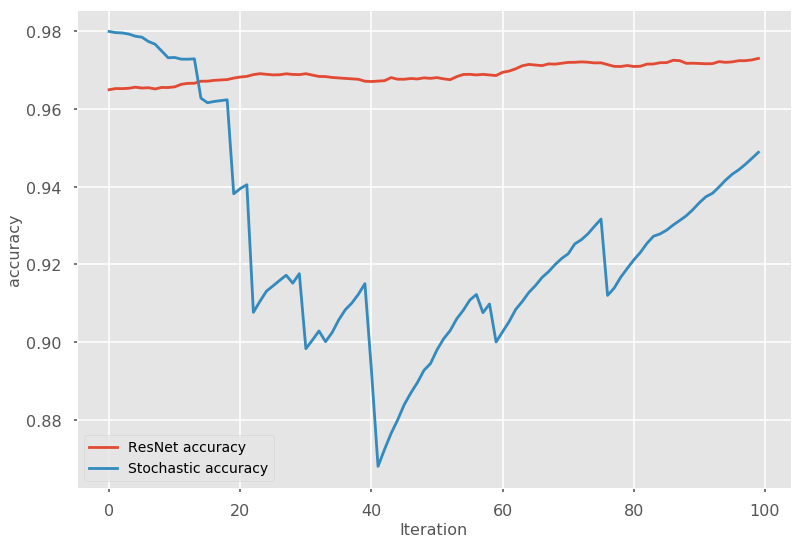

In [8]:
for i in tqn(range(300)):
    res_train_ppl.next_batch(400, n_epochs=None, shuffle=True)
    res_test_ppl.next_batch(400, n_epochs=None, shuffle=True)
    stochastic_train_ppl.next_batch(400, n_epochs=None, shuffle=True)
    stochastic_test_ppl.next_batch(400, n_epochs=None, shuffle=True)
    if i%10==0 and i != 0:
        clear_output(True)
        resnet_loss = res_test_ppl.get_variable('resacc')[-100:]
        stochastic_loss = stochastic_test_ppl.get_variable('stochasticacc')[-100:]
        utils.draw(resnet_loss, 'ResNet', stochastic_loss, 'Stochastic', type_data='accuracy')
        plt.show()

Show test accuracy for all iterations

../utils.py:37: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  firt_ewma = ewma(np.array(first), span=window, adjust=False)
../utils.py:38: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  second_ewma = ewma(np.array(second), span=window, adjust=False) if second else None


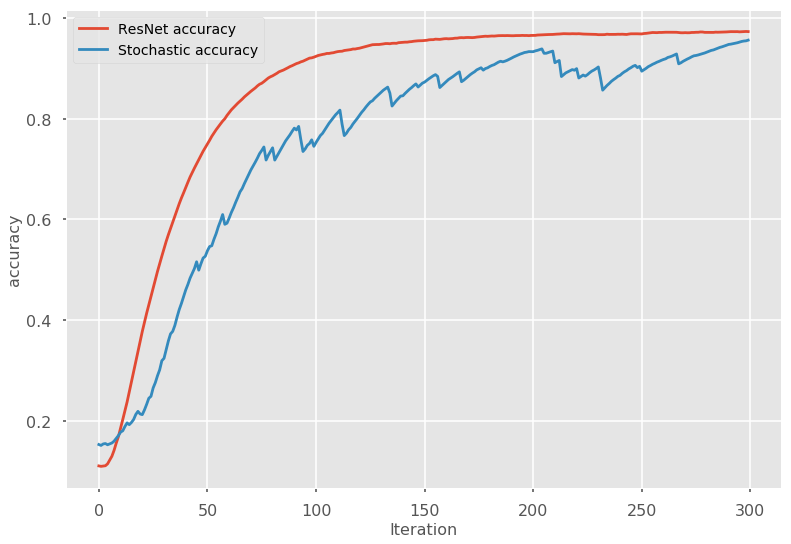

In [10]:
resnet_loss = res_test_ppl.get_variable('resacc')
stochastic_loss = stochastic_test_ppl.get_variable('stochasticacc')
utils.draw(resnet_loss, 'ResNet', stochastic_loss, 'Stochastic', type_data='accuracy')

The graphs show that stochastic model at the beginning loses simple model, but after 200 iteration, it catches up with the usual model for quality and sometimes even overtakes. 